In [1]:
import _pickle as pickle
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import os
import seaborn as sns
import pandas as pd
import timeit


from itertools import product

from utils import set_size, pgf_with_latex

plt.style.use("seaborn-v0_8-colorblind")

# Using the set_size function as defined earlier
doc_width_pt = 452.9679
plt.rcParams.update(pgf_with_latex)

# ERM

In [2]:
n_samples = np.floor(1 * (2 ** np.arange(6, 18)) ** 2)
n_context = 8

p_high = np.arange(1, 10, 2)
p_high = p_high / (p_high + 1)
p_high  = np.concatenate((p_high, np.array([0.99, 0.999])))

print(n_samples)
print(p_high)

[4.09600000e+03 1.63840000e+04 6.55360000e+04 2.62144000e+05
 1.04857600e+06 4.19430400e+06 1.67772160e+07 6.71088640e+07
 2.68435456e+08 1.07374182e+09 4.29496730e+09 1.71798692e+10]
[0.5        0.75       0.83333333 0.875      0.9        0.99
 0.999     ]


In [3]:
n_high = np.floor(n_samples[:, None] * p_high[None, :])
n_low = np.floor(n_samples[:, None] * (1 - p_high[None, :]))

In [4]:
iw_constant = 10
error_iw_high = iw_constant / np.sqrt(n_high)
error_iw_low = iw_constant / np.sqrt(n_low)

In [5]:
p_relevant_high = (n_context - 1) / n_context + p_high / n_context
p_relevant_low = (n_context - 1) / n_context + (1 - p_high) / n_context

n_relevant_high = np.floor(n_high * p_relevant_high)
n_relevant_low = np.floor(n_low * p_relevant_low)

In [6]:
p_relevant_low, p_relevant_high

(array([0.9375    , 0.90625   , 0.89583333, 0.890625  , 0.8875    ,
        0.87625   , 0.875125  ]),
 array([0.9375    , 0.96875   , 0.97916667, 0.984375  , 0.9875    ,
        0.99875   , 0.999875  ]))

In [7]:
ic_constant = 0.00001
error_ic_high = (1 - p_relevant_high) + ic_constant / np.sqrt(n_relevant_high)
error_ic_low = (1 - p_relevant_low) + ic_constant / np.clip(np.sqrt(n_relevant_low), a_min=1e-7, a_max=np.inf)

In [8]:
np.concatenate((error_ic_high.T[..., None], error_iw_high.T[..., None]), axis=-1)

array([[[6.25002282e-02, 2.20970869e-01],
        [6.25001141e-02, 1.10485435e-01],
        [6.25000571e-02, 5.52427173e-02],
        [6.25000285e-02, 2.76213586e-02],
        [6.25000143e-02, 1.38106793e-02],
        [6.25000071e-02, 6.90533966e-03],
        [6.25000036e-02, 3.45266983e-03],
        [6.25000018e-02, 1.72633492e-03],
        [6.25000009e-02, 8.63167458e-04],
        [6.25000004e-02, 4.31583729e-04],
        [6.25000002e-02, 2.15791864e-04],
        [6.25000001e-02, 1.07895932e-04]],

       [[3.12501833e-02, 1.80421959e-01],
        [3.12500917e-02, 9.02109796e-02],
        [3.12500458e-02, 4.51054898e-02],
        [3.12500229e-02, 2.25527449e-02],
        [3.12500115e-02, 1.12763724e-02],
        [3.12500057e-02, 5.63818622e-03],
        [3.12500029e-02, 2.81909311e-03],
        [3.12500014e-02, 1.40954656e-03],
        [3.12500007e-02, 7.04773278e-04],
        [3.12500004e-02, 3.52386639e-04],
        [3.12500002e-02, 1.76193319e-04],
        [3.12500001e-02, 8.80966

In [9]:
np.concatenate((error_ic_low.T[..., None], error_iw_low.T[..., None]), axis=-1)

array([[[6.25002282e-02, 2.20970869e-01],
        [6.25001141e-02, 1.10485435e-01],
        [6.25000571e-02, 5.52427173e-02],
        [6.25000285e-02, 2.76213586e-02],
        [6.25000143e-02, 1.38106793e-02],
        [6.25000071e-02, 6.90533966e-03],
        [6.25000036e-02, 3.45266983e-03],
        [6.25000018e-02, 1.72633492e-03],
        [6.25000009e-02, 8.63167458e-04],
        [6.25000004e-02, 4.31583729e-04],
        [6.25000002e-02, 2.15791864e-04],
        [6.25000001e-02, 1.07895932e-04]],

       [[9.37503283e-02, 3.12500000e-01],
        [9.37501641e-02, 1.56250000e-01],
        [9.37500821e-02, 7.81250000e-02],
        [9.37500410e-02, 3.90625000e-02],
        [9.37500205e-02, 1.95312500e-02],
        [9.37500103e-02, 9.76562500e-03],
        [9.37500051e-02, 4.88281250e-03],
        [9.37500026e-02, 2.44140625e-03],
        [9.37500013e-02, 1.22070312e-03],
        [9.37500006e-02, 6.10351562e-04],
        [9.37500003e-02, 3.05175781e-04],
        [9.37500002e-02, 1.52587

In [10]:
alpha_high = np.argmin(
    np.concatenate((error_ic_high[..., None], error_iw_high[..., None]), axis=-1),
    axis=-1
).T
alpha_low = np.argmin(
    np.concatenate((error_ic_low[..., None], error_iw_low[..., None]), axis=-1),
    axis=-1
).T

In [11]:
alpha_high

array([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [12]:
alpha_low

array([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]])

In [13]:
n_high[0]

array([2048., 3072., 3413., 3584., 3686., 4055., 4091.])

In [14]:
p_high

array([0.5       , 0.75      , 0.83333333, 0.875     , 0.9       ,
       0.99      , 0.999     ])

In [15]:
n_samples.shape

(12,)

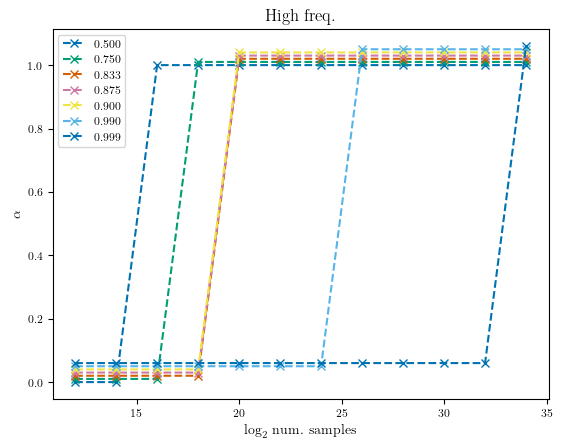

In [16]:
for p_high_i, curr_p_high in enumerate(p_high):
    plt.plot(
        np.log2(n_samples),
        alpha_high[p_high_i] + p_high_i * 0.01,
        label="{:.3f}".format(curr_p_high),
        marker="x",
        linestyle="--",
        alpha=1.0
    )

plt.title("High freq.")
plt.xlabel("$\\log_2$ num. samples")
plt.ylabel("$\\alpha$")
plt.legend()

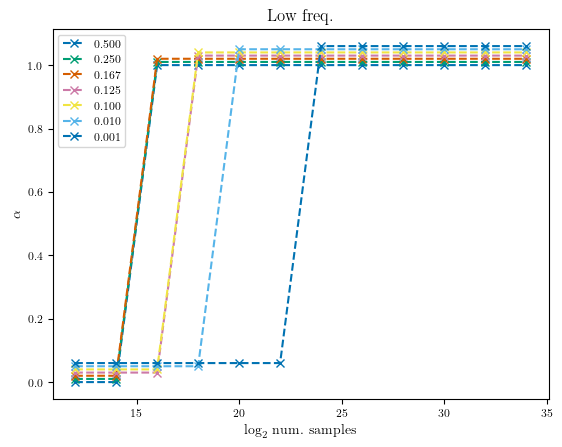

In [17]:
for p_low_i, curr_p_high in enumerate(p_high):
    plt.plot(
        np.log2(n_samples),
        alpha_low[p_low_i] + p_low_i * 0.01,
        label="{:.3f}".format(1 - curr_p_high),
        marker="x",
        linestyle="--",
        alpha=1.0
    )

plt.title("Low freq.")
plt.xlabel("$\\log_2$ num. samples")
plt.ylabel("$\\alpha$")
plt.legend()

# ERM 2

In [172]:
L = 8
C = 10

label_noise = 0.001
label_noise = max(label_noise, 1 - label_noise)

iw_constant = 4096.0
ic_eps = 0.001
B = 1

IW Predictor:
<!-- $$
  R_{{D_x}}(\hat{g}) \leq \min_{y^*} R_{{D_x}}(y^*) + \mathcal{O}\left( \sqrt{ \frac{\log(2\lvert \mathcal{X} \rvert / \delta)}{N_x} } \right)
$$ -->

$$
  \mathbb{E}_y[CE(g(x),y)] \in \mathbb{E}_y[CE(y^*,y)] + \frac{C-1}{2} \frac{\log(N_x)}{N_x} + \Theta(1/N_x)
$$

In [173]:
best_error = -np.log(label_noise)
best_error

0.0010005003335835344

In [174]:
best_error = -label_noise * np.log(label_noise) - C * ((1 - label_noise) / (C - 1)) * np.log((1 - label_noise) / (C - 1))
best_error

0.011116144118048133

In [175]:
n_samples = np.floor(1 * (2 ** np.arange(2, 20)) ** 2)

In [176]:
# iw_errors = best_error + ic_constant * np.sqrt(1 / n_samples)
iw_errors = best_error + (C - 1) / 2 * np.log(n_samples) / n_samples

IC Predictor:
For $L$ contexts and $k$ irrelevant contexts:
$$
  \frac{k(1-\epsilon C)}{k + (L-k)\exp(2\sqrt{B})} + \epsilon(C-1) \le CE(h(\tilde{x}), y) \le -\log \left((1-\epsilon C)\frac{L-k}{L} + \epsilon \right).
$$

With $k = 0$,
$$
  CE(h(\hat{x}), y) = \log \frac{1}{\varepsilon}
$$
where $\varepsilon > 0$ is the minimum probability for all classes

In [177]:
ic_errors = np.zeros((L + 1, 2))
ic_errors[-1] = np.log(1 / ic_eps)

In [178]:
for k in np.arange(0, L):
    ic_errors[k] = [
        (1 - ic_eps * C) * k / (k + (L - k) * np.exp(2 * np.sqrt(B))),
        -np.log((1 - ic_eps * C) * (L - k) / L + ic_eps)
    ]

Plot

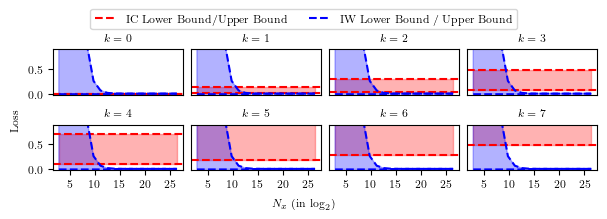

In [179]:
num_rows = 2
num_cols = L // 2

fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=set_size(doc_width_pt, 0.95, (num_rows, num_cols), use_golden_ratio=True),
    layout="constrained",
)

for k in np.arange(L):
    row_i = k // num_cols
    col_i = k % num_cols
    ax = axes[row_i, col_i]
    midpoint = np.mean(ic_errors[k])
    ax.axhline(ic_errors[k, 0], linestyle="--", color="red", label="IC Lower Bound/Upper Bound" if k == 0 else "")
    ax.axhline(ic_errors[k, 1], linestyle="--", color="red")
    ax.fill_between(np.log(n_samples), ic_errors[k, 0], ic_errors[k, 1], color="red", alpha=0.3)

    # ax.plot(np.log(n_samples), iw_errors, color="blue", label="IW Lower Bound/Upper Bound" if k == 0 else "")

    ax.plot(np.log(n_samples), iw_errors + iw_constant / n_samples, linestyle="--", color="blue", label="IW Lower Bound / Upper Bound" if k == 0 else "")
    ax.plot(np.log(n_samples), np.clip(iw_errors - iw_constant / n_samples, a_min=0.0, a_max=np.inf), linestyle="--", color="blue")
    ax.fill_between(np.log(n_samples), iw_errors + iw_constant / n_samples, np.clip(iw_errors - iw_constant / n_samples, a_min=0.0, a_max=np.inf), color="blue", alpha=0.3)
    
    ax.set_ylim(-0.01, max(np.max(ic_errors[:L, 0]), np.max(iw_errors)) + 0.1)

    ax.set_title("$k = {}$".format(k), fontsize="8",)
    loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)

    if row_i < num_rows - 1:
        ax.set_xticks([])
    if col_i > 0:
        ax.set_yticks([])


fig.supxlabel("$N_x$ (in $\\log_2$)", fontsize="8",)
fig.supylabel("Loss", fontsize="8",)
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
# plt.plot()

plt.savefig("toy_example-errors.pdf", dpi=600, format="pdf", bbox_inches="tight")

In [171]:
np.clip(iw_errors - iw_constant / n_samples, a_min=0.0, a_max=np.inf)

array([0.16590672, 0.14728761, 0.06952747, 0.03181109, 0.01781291,
       0.01317109, 0.01172507, 0.01129217, 0.0111661 , 0.01113012,
       0.01112001, 0.0111172 , 0.01111643, 0.01111622, 0.01111617,
       0.01111615, 0.01111615, 0.01111614])